Importing Required Libraries

In [ ]:
!pip install surprise

In [ ]:
import pandas as pd 
import numpy as np
import random
import re 
from surprise import Reader, Dataset, SVD
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#importing the dataset
movies_dataset=pd.read_csv('movies.csv')
ratings_dataset=pd.read_csv('ratings.csv')



##Data Cleaning and Preprocessing 

In [ ]:
#importing the dataset
movies_dataset=pd.read_csv('movies.csv')
ratings_dataset=pd.read_csv('ratings.csv')


In [7]:
movies_dataset

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [11]:
movies_dataset['movieId'].nunique()

9742

In [8]:
ratings_dataset

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [16]:
ratings_dataset['movieId'].nunique()


9724

In [18]:
ratings_dataset['userId'].nunique()

610

In [20]:
ratings_dataset['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [23]:
ratings_dataset['rating'].min()

0.5

In [24]:
ratings_dataset['rating'].max()

5.0

In [25]:
ratings_dataset['timestamp'].max() #unix time stamp which means Sept 2018

1537799250

In [26]:
ratings_dataset['timestamp'].min() #unix time stamp which means March 1996

828124615

In [31]:
#number of records for different ratings 
a=ratings_dataset.groupby(['rating']).count().reset_index()
a

,rating,userId,movieId,timestamp
0,0.5,1370,1370,1370
1,1.0,2811,2811,2811
2,1.5,1791,1791,1791
3,2.0,7551,7551,7551
4,2.5,5550,5550,5550
5,3.0,20047,20047,20047
6,3.5,13136,13136,13136
7,4.0,26818,26818,26818
8,4.5,8551,8551,8551
9,5.0,13211,13211,13211


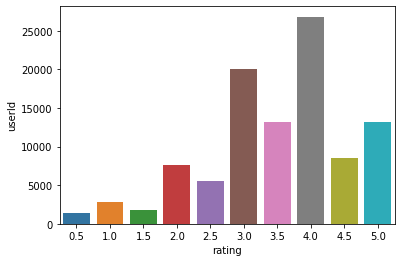

In [32]:
#graph of number of records for different ratings - majority of the movies are given 4 rating
import seaborn as sns
ax = sns.barplot(x="rating", y="userId", data=a)

# Data pre-processing

In [5]:

#Converting the format of Genre column to a list and then appending to the new list
Genre=[]
Genres={}
for num in range(0,len(movies_dataset)):
    key=movies_dataset.iloc[num]['title']
    value=movies_dataset.iloc[num]['genres'].split('|')
    Genres[key]=value
    Genre.append(value)


In [35]:
Genre

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy'],
 ['Action', 'Crime', 'Thriller'],
 ['Comedy', 'Romance'],
 ['Adventure', 'Children'],
 ['Action'],
 ['Action', 'Adventure', 'Thriller'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy', 'Horror'],
 ['Adventure', 'Animation', 'Children'],
 ['Drama'],
 ['Action', 'Adventure', 'Romance'],
 ['Crime', 'Drama'],
 ['Drama', 'Romance'],
 ['Comedy'],
 ['Comedy'],
 ['Action', 'Comedy', 'Crime', 'Drama', 'Thriller'],
 ['Comedy', 'Crime', 'Thriller'],
 ['Crime', 'Drama', 'Horror', 'Mystery', 'Thriller'],
 ['Action', 'Crime', 'Thriller'],
 ['Drama', 'Sci-Fi'],
 ['Drama', 'Romance'],
 ['Drama'],
 ['Children', 'Drama'],
 ['Drama', 'Romance'],
 ['Adventure', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi'],
 ['Crime', 'Drama'],
 ['Drama'],
 ['Mystery', 'Sci-Fi', 'Thriller'],
 ['Children', 'Drama'],
 ['Crime', 'Drama'],
 ['Children', 'Comedy'],
 

In [39]:
#Number of unique Genres
res = list(set(i for j in Genre for i in j))
len(res)

20

In [40]:
#unique genres in the dataset
res

['Comedy',
 'Fantasy',
 'Horror',
 'Documentary',
 'Mystery',
 'Sci-Fi',
 '(no genres listed)',
 'Action',
 'Romance',
 'Thriller',
 'Children',
 'Crime',
 'IMAX',
 'Western',
 'Film-Noir',
 'Drama',
 'Musical',
 'Animation',
 'Adventure',
 'War']

In [56]:
df=pd.DataFrame(columns=['Genre','Count'])
c=0
for i in res:
    a=sum(x.count(i) for x in Genre)
    df.loc[c,'Genre']=i
    df.loc[c,'Count']=a
    c=c+1
df

,Genre,Count
0,Comedy,3756
1,Fantasy,779
2,Horror,978
3,Documentary,440
4,Mystery,573
5,Sci-Fi,980
6,(no genres listed),34
7,Action,1828
8,Romance,1596
9,Thriller,1894


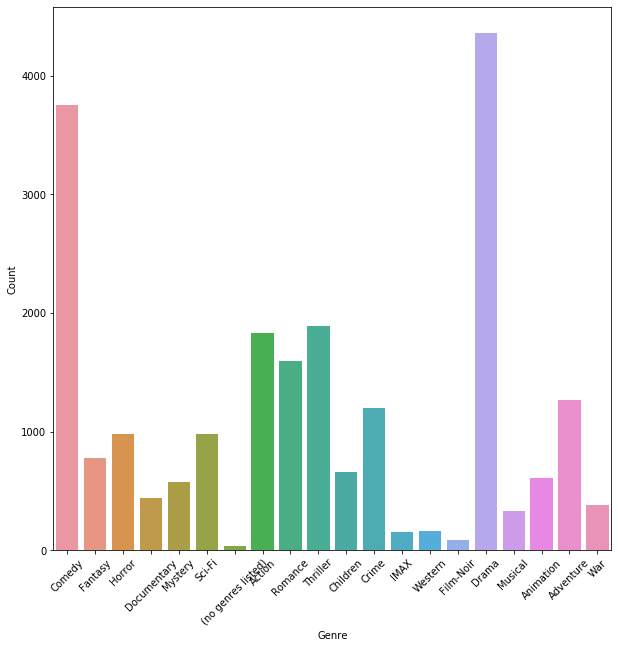

In [61]:
#graph of number of records for different ratings - majority of the movies are given 4 rating
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
plt.xticks(rotation=45)
ax = sns.barplot(x="Genre", y="Count", data=df)

In [62]:

    
#Making a new column in our original Dataset         
movies_dataset['new'] =Genre
movies_dataset

,movieId,title,genres,new
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),Drama,[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[Action, Animation]"


In [63]:

#Getting the year from the movie column 
p = re.compile(r"(?:\((\d{4})\))?\s*$")
years=[]
for movies in movies_dataset['title']:
     m = p.search(movies)
     year = m.group(1)
     years.append(year)  
movies_dataset['year']=years
#movies_dataset

,movieId,title,genres,new,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],1995
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[Animation, Comedy, Fantasy]",2017
9739,193585,Flint (2017),Drama,[Drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[Action, Animation]",2018


In [64]:

#Deleting the year from the movies title column
movies_name=[]
raw=[]
for movies in movies_dataset['title']:
     m = p.search(movies)
     year = m.group(0)
     new=re.split(year,movies)
     raw.append(new)  
for i in range(len(raw)):
    movies_name.append(raw[i][0][:-2].title())
    

movies_dataset['movie_name']=movies_name
movies_dataset


,movieId,title,genres,new,year,movie_name
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",1995,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",1995,Waiting To Exhale
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],1995,Father Of The Bride Part Ii
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[Action, Animation, Comedy, Fantasy]",2017,Black Butler: Book Of The Atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[Animation, Comedy, Fantasy]",2017,No Game No Life: Zero
9739,193585,Flint (2017),Drama,[Drama],2017,Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[Action, Animation]",2018,Bungo Stray Dogs: Dead Apple


In [65]:
#Converting the datatype of new column from list to string as required by the function
movies_dataset['new']=movies_dataset['new'].apply(' '.join)
movies_dataset

,movieId,title,genres,new,year,movie_name
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,1995,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,1995,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,1995,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,1995,Waiting To Exhale
4,5,Father of the Bride Part II (1995),Comedy,Comedy,1995,Father Of The Bride Part Ii
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Action Animation Comedy Fantasy,2017,Black Butler: Book Of The Atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,Animation Comedy Fantasy,2017,No Game No Life: Zero
9739,193585,Flint (2017),Drama,Drama,2017,Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Action Animation,2018,Bungo Stray Dogs: Dead Apple


# Content Based Filtering and Collaborative filtering

In [25]:
"""Applying the Content Based Filtering"""
# Feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

tfid=TfidfVectorizer(stop_words='english')
matrix=tfid.fit_transform(movies_dataset['new'])

#Compute the cosine similarity of every genre
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim=cosine_similarity(matrix,matrix)

"""Applying the Collaborative Filtering"""
#Intialising the Reader which is used to parse the file containing the ratings 
reader=Reader()
dataset=Dataset.load_from_df(ratings_dataset[['userId','movieId','rating']],reader)

#Benchmarking with various Algorithms
benchmark = []
# Iterating over all algorithms
for algorithm in [SVD(),SVDpp(),SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Performing  cross validation
    results = cross_validate(algorithm, dataset, measures=['AME','RMSE'], cv=3 ,verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
bench = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
bench.to_csv("benchmark.csv")   




Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8806  0.8740  0.8854  0.8800  0.0047  
Fit time          3.28    3.30    3.36    3.31    0.03    
Test time         0.21    0.21    0.32    0.25    0.05    
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8703  0.8726  0.8660  0.8696  0.0027  
Fit time          299.28  296.43  290.40  295.37  3.70    
Test time         12.10   11.72   11.97   11.93   0.16    
Evaluating RMSE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8996  0.9153  0.9085  0.9078  0.0064  
Fit time          3.36    3.66    3.53    3.52    0.12    
Test time         7.95    7.98    7.85    7.93    0.05    
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9347  0.93

##Recommendation Function

In [ ]:
def recommendation(movie):
    result=[]
    #Getting the id of the movie for which the user want recommendation
    ind=indices[movie]
    
    #Getting all the similar cosine score for that movie
    sim_scores=list(enumerate(cosine_sim[ind]))
    
    #Sorting the list obtained
    sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=True) 
    
    #Getting all the id of the movies that are related to the movie Entered by the user
    movie_id=[i[0] for i in sim_scores]    
    print('The Movie You Should Watched Next Are --')
    print('ID ,   Name ,  Average Ratings , Year ')
    
    #Varible to print only top 10 movies
    count=0
    for id in range(0,len(movie_id)):
      #to ensure that the movie entered by the user is doesnot come in his/her recommendation
        if(ind != movie_id[id]):
            ratings=ratings_dataset[ratings_dataset['movieId']==movie_id[id]]['rating']
            avg_ratings=round(np.mean(ratings),2)
            #To print only thoese movies which have an average ratings that is more than 3.5
            if(avg_ratings >3.5):
                count+=1
                print(f'{movie_id[id]} , {titles[movie_id[id]]} ,{avg_ratings}')
                result.append([titles[movie_id[id]],str(avg_ratings)])
            if(count >=10):
                    break
    
    print('Accumulating your Recommendations')
    return result


##Calling the Function to get Recommendations

In [ ]:
#making the dataset to train our model
train=dataset.build_full_trainset()

#Movie name and movie id 
movies_dataset = movies_dataset.reset_index()
titles = movies_dataset['movie_name']
indices = pd.Series(movies_dataset.index, index=movies_dataset['movie_name'])
#Function to make recommendation to the user

    
#Getting the output   

movie_name=(input('Enter Movie name - '))
result=recommendataion(movie_name)
print(result)
